### Momentum

We consider momentum defined at different periods to see how it performs for our targeted time horizon of one month forward returns.

In [445]:
import yfinance as yf
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

load_dotenv()

db_url = os.getenv('DB_URL')
psql = create_engine(db_url)

In [455]:
monthly_data = pd.read_sql('select * from adjusted_monthly', psql)

We consider the following horizons for the momentum calculation:
1. `T-12 to T-1`, how Jegadeesh and Titman originally defined momentum
2. `T-6 to T-1`
3. `T-2 to T-1` (most recent month excluding the current month)

In [456]:
monthly_data = monthly_data.sort_values(['ticker','date'])

monthly_data['adj_close_12m'] = monthly_data.groupby('ticker')['adj_close'].shift(12)
monthly_data['adj_close_6m'] = monthly_data.groupby('ticker')['adj_close'].shift(6)
monthly_data['adj_close_2m'] = monthly_data.groupby('ticker')['adj_close'].shift(2)
monthly_data['adj_close_1m'] = monthly_data.groupby('ticker')['adj_close'].shift(1)

# calc momentum metrics
monthly_data['mom_12m_1m'] = monthly_data['adj_close_1m'] / monthly_data['adj_close_12m'] - 1
monthly_data['mom_6m_1m'] = monthly_data['adj_close_1m'] / monthly_data['adj_close_6m'] - 1
monthly_data['mom_2m_1m'] = monthly_data['adj_close_1m'] / monthly_data['adj_close_2m'] - 1

monthly_data['adj_return'] = (
    monthly_data.groupby('ticker')['adj_close'].pct_change(fill_method=None)
)
monthly_data['adj_return_fwd'] = (
    monthly_data.groupby('ticker')['adj_return'].shift(-1)
)

In [457]:
monthly_data_no_na = monthly_data.dropna()

Now consider the forward looking information coefficient of each momentum metric.

In [458]:
momentum_stats = []

# should probably vectorise this but i am not bothered right now
for date, data in monthly_data_no_na.groupby('date'):
    mom_12m = data['adj_return_fwd'].corr(data['mom_12m_1m'], method='spearman')
    mom_6m = data['adj_return_fwd'].corr(data['mom_6m_1m'], method='spearman')
    mom_2m = data['adj_return_fwd'].corr(data['mom_2m_1m'], method='spearman')

    momentum_stats.append({
        'date': date,
        'mom_12m': mom_12m,
        'mom_6m': mom_6m,
        'mom_2m': mom_2m
    })

In [459]:
momentum_stats_df = pd.DataFrame(momentum_stats)

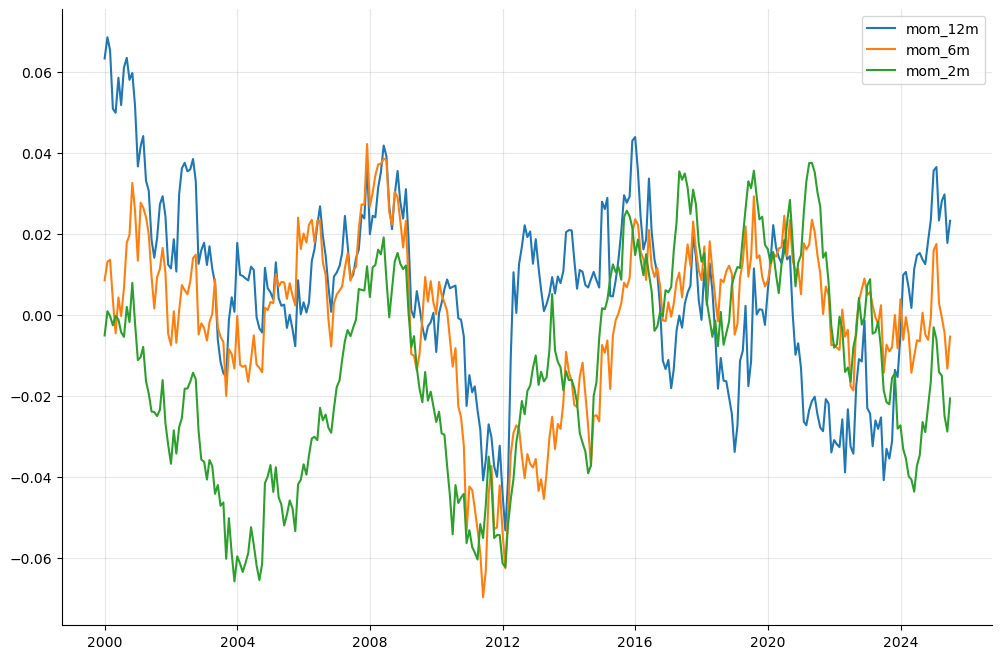

In [460]:
momentums = ['mom_12m', 'mom_6m', 'mom_2m']

plt.figure(figsize=(12, 8))
for m in momentums:
    rolling_m = momentum_stats_df[m].rolling(window = 36).mean()

    plt.plot(momentum_stats_df['date'], rolling_m, label=m)

plt.grid(alpha=0.3)
sns.despine()
plt.legend()

In [461]:
for m in momentums:
    print(f'Median of {m} IC: {momentum_stats_df[m].median()}')

Median of mom_12m IC: 0.022959173116799382
Median of mom_6m IC: -0.0002693215908728221
Median of mom_2m IC: -0.006271238806408836


It appears that the 12 month to 1 month momentum is the best momentum for us to use.